In [2]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re  # For text cleaning
import os

# Set seaborn style for visualizations
sns.set(style="whitegrid")

# Load the dataset (use low_memory=False to avoid dtype warnings)
data_path = r"C:\Users\hp\Pictures\financial intelligence\Intelligent-Complaint-Analysis-for-Financial-Services\rag-complaint-chatbot\data\raw\complaints.csv"
df = pd.read_csv(data_path)

# Display basic info
print(df.info())  # Shows column names, non-null counts, dtypes
print(df.head())  # First 5 rows
print(f"Total rows: {len(df)}")  # Should be ~4M+ depending on download date

C:\Users\hp\AppData\Local\Temp\ipykernel_16160\727135001.py:14: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9609797 entries, 0 to 9609796
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(1), object(17)
memory usage: 1.3+

Product Distribution:
 Product
Credit reporting or other personal consumer reports                             4834855
Credit reporting, credit repair services, or other personal consumer reports    2163857
Debt collection                                                                  799197
Mortgage                                                                         422254
Checking or savings account                                                      291178
Credit card                                                                      226686
Credit card or prepaid card                                                      206369
Money transfer, virtual currency, or money service                               145066
Credit reporting                                                                 140429
Student loan                                                                     109717
Bank account or service                                                           86205
V

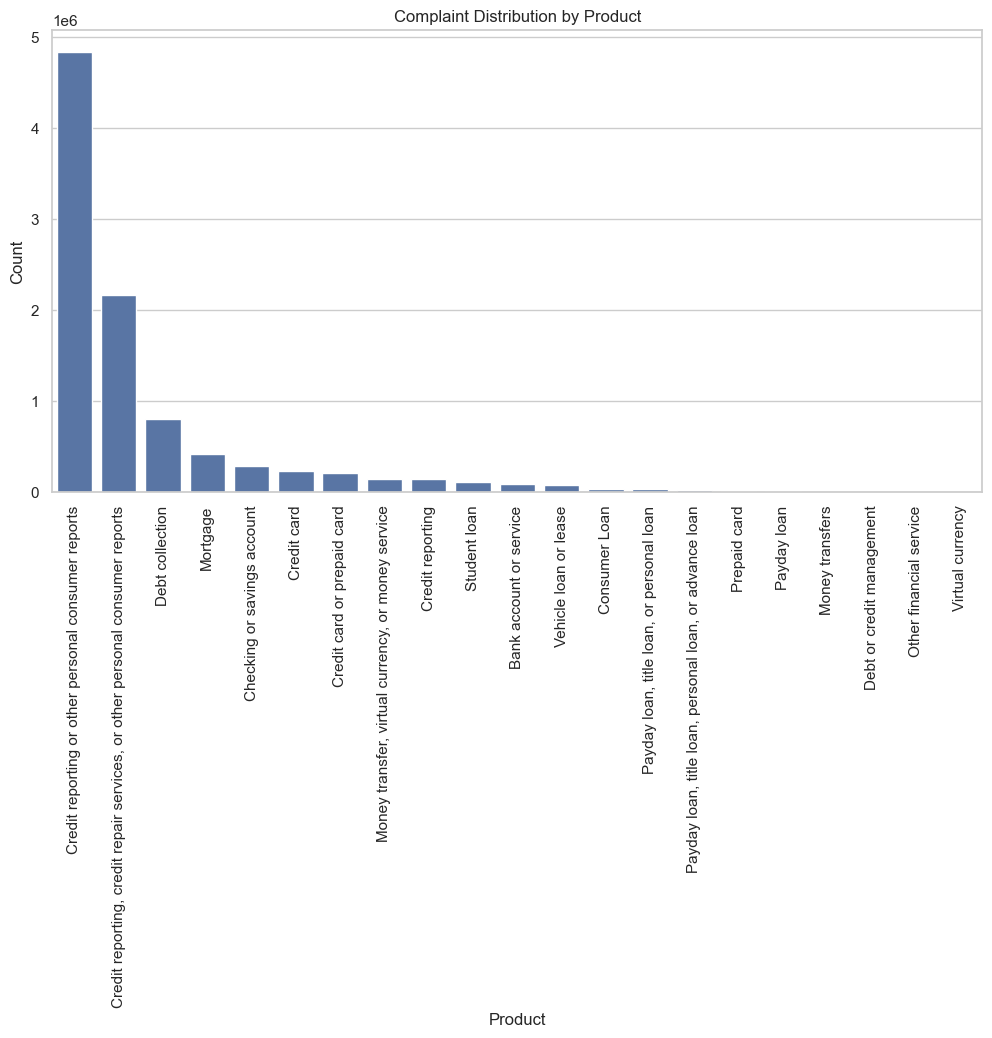

Narrative Length Stats:
 count    9.609797e+06
mean     5.446667e+01
std      1.497672e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      5.000000e+01
max      6.469000e+03
Name: narrative_length, dtype: float64


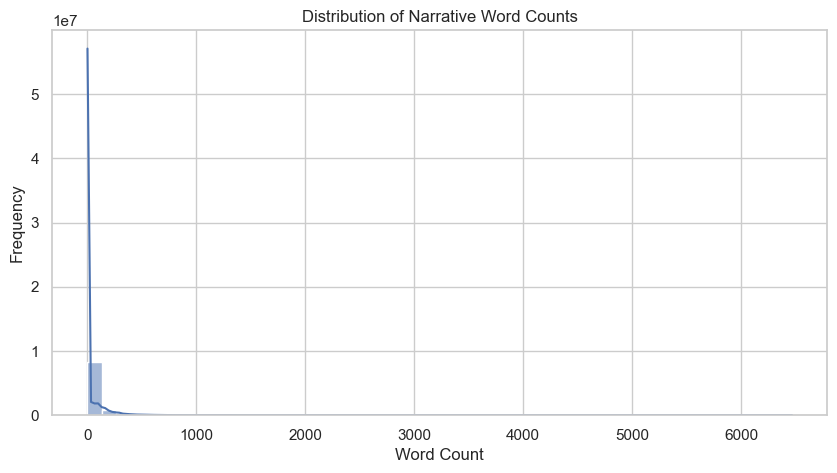

Short narratives: 6650979
Long narratives: 32428
Complaints with narratives: 2980756
Complaints without narratives: 6629041


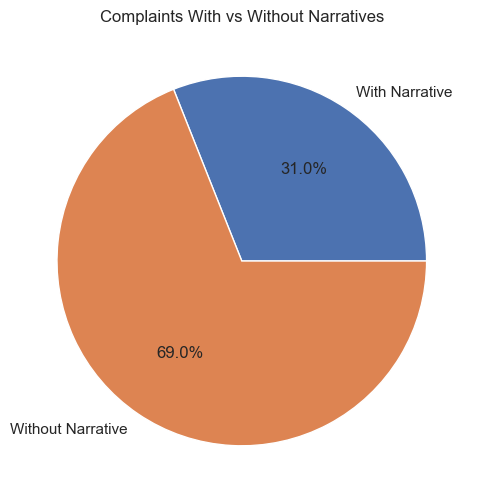

In [3]:
# Step 2.1: Analyze distribution of complaints across Products
product_distribution = df['Product'].value_counts()
print("Product Distribution:\n", product_distribution)

# Visualize
plt.figure(figsize=(12, 6))
sns.barplot(x=product_distribution.index, y=product_distribution.values)
plt.xticks(rotation=90)
plt.title('Complaint Distribution by Product')
plt.xlabel('Product')
plt.ylabel('Count')
plt.show()

# Step 2.2 Calculate and visualize narrative lengths (word count)
# Add a column for word count (handle NaN narratives)
df['narrative_length'] = df['Consumer complaint narrative'].apply(
    lambda x: len(str(x).split()) if pd.notnull(x) else 0
)

# Statistics
print("Narrative Length Stats:\n", df['narrative_length'].describe())

# Visualize histogram
plt.figure(figsize=(10, 5))
sns.histplot(df['narrative_length'], bins=50, kde=True)
plt.title('Distribution of Narrative Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

# Identify very short (<10 words) or very long (>1000 words) narratives
short_narratives = df[df['narrative_length'] < 10]
long_narratives = df[df['narrative_length'] > 1000]
print(f"Short narratives: {len(short_narratives)}")
print(f"Long narratives: {len(long_narratives)}")

# Step 4.3: Identify complaints with and without narratives
with_narrative = df['Consumer complaint narrative'].notnull().sum()
without_narrative = df['Consumer complaint narrative'].isnull().sum()
print(f"Complaints with narratives: {with_narrative}")
print(f"Complaints without narratives: {without_narrative}")

# Visualize
plt.figure(figsize=(6, 6))
plt.pie([with_narrative, without_narrative], labels=['With Narrative', 'Without Narrative'], autopct='%1.1f%%')
plt.title('Complaints With vs Without Narratives')
plt.show()

In [4]:
# Define the target products (match CFPB naming closely; adjust based on your EDA)
target_products = [
    'Credit card',  # May appear as 'Credit card or prepaid card'
    'Consumer Loan',  # For Personal Loans
    'Bank account or service',  # For Savings Accounts
    'Money transfers'  # For Money Transfers
]
# Note: Check exact names from your product_distribution print. CFPB uses:
# - 'Credit card' or 'Credit card or prepaid card'
# - 'Consumer Loan' for personal loans
# - 'Bank account or service' for savings
# - 'Money transfer' or 'Money transfers'

# Filter to target products
filtered_df = df[df['Product'].isin(target_products)]

# Remove records with empty narratives
filtered_df = filtered_df[filtered_df['Consumer complaint narrative'].notnull()]

# Additional filter: Remove very short narratives (optional, e.g., <10 words)
filtered_df = filtered_df[filtered_df['narrative_length'] >= 10]

print(f"Filtered rows: {len(filtered_df)}")

Filtered rows: 106104


In [5]:
# Define a cleaning function
def clean_narrative(text):
    if pd.isnull(text):
        return ""
    text = text.lower()  # Lowercase
    text = re.sub(r'[^a-z0-9\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    # Remove boilerplate (example patterns; customize based on EDA)
    boilerplate_patterns = [
        r'i am writing to file a complaint',
        r'this is a formal complaint'
    ]
    for pattern in boilerplate_patterns:
        text = re.sub(pattern, '', text, flags=re.IGNORECASE)
    return text

# Apply cleaning
filtered_df['cleaned_narrative'] = filtered_df['Consumer complaint narrative'].apply(clean_narrative)

# Optional: Other normalizations (e.g., remove stopwords using NLTK)
# import nltk
# from nltk.corpus import stopwords
# nltk.download('stopwords')
# stop_words = set(stopwords.words('english'))
# filtered_df['cleaned_narrative'] = filtered_df['cleaned_narrative'].apply(
#     lambda x: ' '.join([word for word in x.split() if word not in stop_words])
# )

# Verify cleaning
print(filtered_df[['Consumer complaint narrative', 'cleaned_narrative']].head())

                            Consumer complaint narrative  \
12237  A XXXX XXXX card was opened under my name by a...   
13280  Dear CFPB, I have a secured credit card with c...   
13506  I have a Citi rewards cards. The credit balanc...   
13955  b'I am writing to dispute the following charge...   
14249  Although the account had been deemed closed, I...   

                                       cleaned_narrative  
12237  a xxxx xxxx card was opened under my name by a...  
13280  dear cfpb i have a secured credit card with ci...  
13506  i have a citi rewards cards the credit balance...  
13955  bi am writing to dispute the following charges...  
14249  although the account had been deemed closed i ...  


In [6]:
# Save to CSV
output_path = r"c:\Users\hp\Pictures\financial intelligence\Intelligent-Complaint-Analysis-for-Financial-Services\rag-complaint-chatbot\data\processed/filtered_complaints.csv"  # Note: The task says data/filtered_complaints.csv, but structure has data/processed/
os.makedirs(r"c:\Users\hp\Pictures\financial intelligence\Intelligent-Complaint-Analysis-for-Financial-Services\rag-complaint-chatbot\data\processed", exist_ok=True)
filtered_df.to_csv(output_path, index=False)
print(f"Saved filtered dataset to {output_path}")

Saved filtered dataset to c:\Users\hp\Pictures\financial intelligence\Intelligent-Complaint-Analysis-for-Financial-Services\rag-complaint-chatbot\data\processed/filtered_complaints.csv
